In [1]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import os

/Users/amitchaubey/anaconda3/lib/python3.11/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [4]:
# --- Model architecture that matches our trained model ---
class ConvLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super().__init__()
        padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(padding)
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        return self.conv2d(self.reflection_pad(x))

class ResidualBlock(torch.nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = torch.nn.Sequential(
            ConvLayer(channels, channels, kernel_size=3, stride=1),
            torch.nn.InstanceNorm2d(channels, affine=True),
            torch.nn.ReLU(inplace=True),
            ConvLayer(channels, channels, kernel_size=3, stride=1),
            torch.nn.InstanceNorm2d(channels, affine=True),
        )

    def forward(self, x):
        return x + self.block(x)

class UpsampleConvLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=None):
        super().__init__()
        self.upsample = upsample
        padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(padding)
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        if self.upsample:
            x = torch.nn.functional.interpolate(x, scale_factor=self.upsample, mode='nearest')
        return self.conv2d(self.reflection_pad(x))

class TransformerNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torch.nn.Sequential(
            ConvLayer(3, 32, kernel_size=9, stride=1),
            torch.nn.InstanceNorm2d(32, affine=True),
            torch.nn.ReLU(inplace=True),
            ConvLayer(32, 64, kernel_size=3, stride=2),
            torch.nn.InstanceNorm2d(64, affine=True),
            torch.nn.ReLU(inplace=True),
            ConvLayer(64, 128, kernel_size=3, stride=2),
            torch.nn.InstanceNorm2d(128, affine=True),
            torch.nn.ReLU(inplace=True),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            UpsampleConvLayer(128, 64, kernel_size=3, stride=1, upsample=2),
            torch.nn.InstanceNorm2d(64, affine=True),
            torch.nn.ReLU(inplace=True),
            UpsampleConvLayer(64, 32, kernel_size=3, stride=1, upsample=2),
            torch.nn.InstanceNorm2d(32, affine=True),
            torch.nn.ReLU(inplace=True),
            ConvLayer(32, 3, kernel_size=9, stride=1)
        )

    def forward(self, x):
        return self.model(x)

# --- Utility function ---
# def stylize_image(model_path, content_image_path, output_dir="output", image_size=512):
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#     # Load model
#     model = TransformerNet().to(device)
#     model.load_state_dict(torch.load(model_path, map_location=device))
#     model.eval()

#     # Load content image
#     image = Image.open(content_image_path).convert('RGB')
#     transform = transforms.Compose([
#         transforms.Resize(image_size),
#         transforms.ToTensor(),
#         transforms.Lambda(lambda x: x.mul(255))
#     ])
#     content_tensor = transform(image).unsqueeze(0).to(device)

#     # Stylize
#     with torch.no_grad():
#         output_tensor = model(content_tensor).cpu()

#     # Convert back to PIL
#     output_image = output_tensor.squeeze(0).clamp(0, 255).detach().numpy()
#     output_image = output_image.transpose(1, 2, 0).astype('uint8')
#     output_image = Image.fromarray(output_image)

#     # Save the stylized image
#     os.makedirs(output_dir, exist_ok=True)
#     content_basename = os.path.splitext(os.path.basename(content_image_path))[0]
#     output_path = os.path.join(output_dir, f"stylized_{content_basename}.jpg")
#     output_image.save(output_path)

#     # Display images
#     plt.figure(figsize=(12,6))

#     plt.subplot(1, 2, 1)
#     plt.imshow(image)
#     plt.title('Original Content')
#     plt.axis('off')

#     plt.subplot(1, 2, 2)
#     plt.imshow(output_image)
#     plt.title('Stylized Output')
#     plt.axis('off')

#     plt.tight_layout()
#     plt.show()

#     print(f"Stylized image saved at: {output_path}")

from PIL import Image

def load_image(filename, size=None, scale=None):
    img = Image.open(filename).convert('RGB')
    if size is not None:
        img = img.resize((size, size), Image.Resampling.LANCZOS)
    elif scale is not None:
        new_size = (int(img.width * scale), int(img.height * scale))
        img = img.resize(new_size, Image.Resampling.LANCZOS)
    # else: keep original size
    return img



def stylize_image(model_path, content_image_path, output_dir="output", image_scale=1.0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load model
    model = TransformerNet().to(device)
    state_dict = torch.load(model_path, map_location=device)

    # Clean deprecated keys if necessary
    for k in list(state_dict.keys()):
        if "running_mean" in k or "running_var" in k:
            del state_dict[k]

    model.load_state_dict(state_dict)
    model.eval()

    # Load content image without forcing resize
    content_image = load_image(content_image_path)
    transform = transforms.ToTensor()
    content_tensor = transform(content_image).unsqueeze(0).mul(255).to(device)

    # Stylize
    with torch.no_grad():
        output_tensor = model(content_tensor).cpu()

    # Convert tensor back to image
    output_image = output_tensor.squeeze(0).clamp(0, 255).numpy()
    output_image = output_image.transpose(1, 2, 0).astype('uint8')
    output_image = Image.fromarray(output_image)

    # Save output
    os.makedirs(output_dir, exist_ok=True)
    content_basename = os.path.splitext(os.path.basename(content_image_path))[0]
    output_path = os.path.join(output_dir, f"stylized_{content_basename}.jpg")
    output_image.save(output_path)

    # Display side-by-side
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.imshow(content_image)
    plt.title('Original Content')
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(output_image)
    plt.title('Stylized Output')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    print(f"Stylized image saved at: {output_path}")



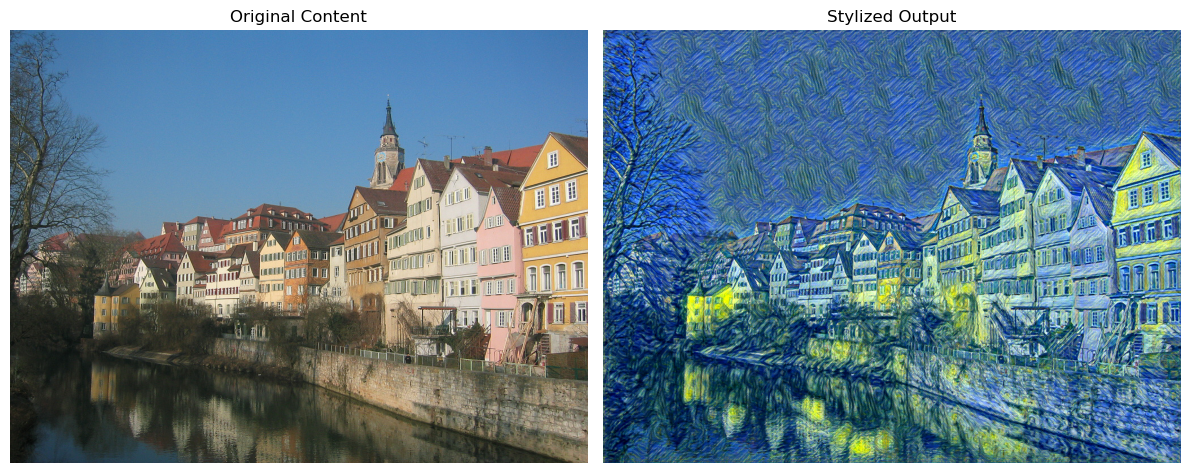

Stylized image saved at: output/stylized_Tuebingen_Neckarfront.jpg


In [13]:

model_path = '/Users/amitchaubey/My Drive/collab_notebooks/fast_transfer_project/data/models/final_improved.pth'
content_image_path = "/Users/amitchaubey/project/nst_app/content_images/Tuebingen_Neckarfront.jpg"
stylize_image(model_path, content_image_path)

In [5]:
model_path = '/Users/amitchaubey/My Drive/collab_notebooks/fast_transfer_project/data/models/final_improved.pth'
content_image_path = "/Users/amitchaubey/project/nst_app/content_images/ACP_5369.jpg"
stylize_image(model_path, content_image_path)

: 